## Quantum Optimal control to optimize the linear schedule

 comments go here

#### Imports

In [2]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Define the Class schedule with both power law expansion and F-CRAB initialization

comments go here

In [26]:
class Schedule:
    
    def __init__(self,tf:float,type:str,number_of_parameters:int,nsteps:int):
        
        self.tf=tf
        self.type=type
        self.time=np.linspace(0,self.tf,nsteps)
        self.parameters=np.zeros(number_of_parameters)
        
    def get_driving(self)-> np.ndarray:
        
        if self.type=='power law':
            matrix=(self.parameters[:,None]*(self.time[None,:]/self.tf)**np.arange(1,self.parameters.shape[0]+1)[:,None])
            h=(1-self.time/self.tf)*(1+np.sum(matrix,axis=0))
        return h

Plot some samples of the driving

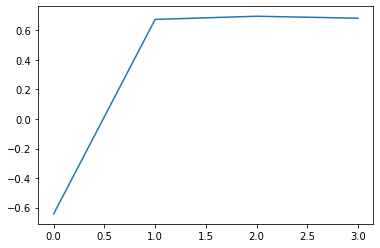

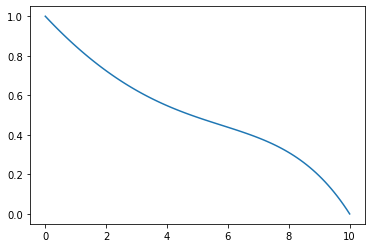

In [37]:
PowerLawScheduler=Schedule(tf=10,type='power law',number_of_parameters=4,nsteps=100)

PowerLawScheduler.parameters=np.random.uniform(-1,1,size=PowerLawScheduler.parameters.shape[0])
plt.plot(PowerLawScheduler.parameters)
plt.show()
h=PowerLawScheduler.get_driving()

plt.plot(PowerLawScheduler.time,h)
plt.show()

#### Function to optimize (as a class)

In [ ]:
class SchedulerModel(Schedule):
    
    def __init__(self,initial_state:np.ndarray,target_hamiltonian: scipy.sparse.spmatrix,initial_hamiltonian: scipy.sparse.spmatrix,tf:float,number_of_parameters:int,nsteps:int):
        
        super().__init__(tf=tf,type='power law', number_of_parameters=number_of_parameters,nsteps=nsteps)
        self.target_hamiltonian=target_hamiltonian
        self.initial_hamiltonian=initial_hamiltonian
        self.initial_state=initial_state
        
        
        self.energy=1000
    def forward(self):
        psi=self.initial_state
        dt=self.time[1]-self.time[0]
        
        h=self.get_driving()
        
        for i,t in enumerate(self.time):
            time_hamiltonian=h[i]*self.initial_hamiltonian+(1-h[i])*self.target_hamiltonian
            psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        self.energy=psi.conjugete().transpose().dot(self.target_hamiltonian.dot(psi))
        return self.energy
    
    def callback(self):
        
        print(self.energy)    
        
        